# beta distribution
The distribution is
\begin{equation}
    \begin{split}
        f(x;\alpha,\beta) &= \dfrac{x^{\alpha-1}(1-x)^{\beta-1}}{\int_0^1 u^{\alpha-1}(1-u)^{\beta-1} du} \\
        & = \dfrac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}x^{\alpha-1}(1-x)^{\beta-1} \\
        & = \dfrac{1}{B(\alpha, \beta)}x^{\alpha-1}(1-x)^{\beta-1}
    \end{split}
\end{equation}
$\Gamma$ and $B$ are gamma and beta function respectively.

Average and variance are,
\begin{equation}
    \begin{split}
        \bar{X} &= \dfrac{\alpha}{\alpha+\beta} \\
        \bar{X\prime\prime^2} &= \dfrac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)} 
    \end{split}
\end{equation}
With the mean and variance,
\begin{equation}
    \begin{split}
        \alpha & = \bar{X}\left(\dfrac{1}{\eta_X}-1\right) \\
        \beta & = \left(1-\bar{X}\right)\left(\dfrac{1}{\eta_X}-1\right)
    \end{split}
\end{equation}
where
\begin{equation}
    \eta_X = \dfrac{\bar{X\prime\prime^2}}{\bar{X}\left(1-\bar{X}\right)}
\end{equation}

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as P
from scipy.integrate import simps
from scipy.stats import beta
from scipy.interpolate import interp1d
import scipy as sp

In [2]:
def beta_coef(ave, var):
    """Obtain the coefficients for beta distribution with average and variance"""
    a = ave*(1./var-1.)
    b = (1.-ave)*(1./var-1.)
    return a, b

In [3]:
# Numerical Integration

In [4]:
def beta_integration_direct(f, x, a, b, fit='cubic'):
    """Integrate over the given sample, intepolate pdf at the boundary"""
    # f(x): function value
    # x: axis points
    # a: alpha for the beta distribution
    # b: beta for the beta distribution
    # fit: fitting formula
    
    rv = beta(a, b)
    pdf = rv.pdf(x)
    
    y = interp1d(x[1:-1], pdf[1:-1],
                 kind=fit,
                 fill_value='extrapolate'
                )
    
    if a < 1. :
        pdf[0] = y(0.) if y(0.) > 0. else 0.
    if b < 1. :
        pdf[-1] = y(1.) if y(1.) > 0. else 0.
        
    return simps(f*pdf, x)

In [5]:
def beta_integration_log(f, x, a, b, fit='cubic', epsilon=1.e-9, n_ext=100):
    """Integrate over the given sample, log spaced intepolation of function and pdf towards the boundary"""
    
    f_interp = interp1d(f, x,
                        kind = fit,
                        fill_value = 'extrapolate'
                       )
    
    if a < 1.:
        x_ext = np.logspace(np.log10(epsilon),
                            np.log10(x[1]), 
                            num=n_ext
                           )
        x_ext = np.insert(x_ext, 0, 0.)
        f_ext = f_interp(x_ext)
        
        x = np.hstack((x_ext, x[2:]))
        f = np.hstack((f_ext, f[2:]))
    
    if b < 1.:
        x_ext = np.logspace(np.log10(epsilon), 
                            np.log10(1.-x[-2]), 
                            num=n_ext
                           )
        x_ext = np.flip( 1. - np.insert(x_ext, 0, 0.) )
        f_ext = f_interp(x_ext)
        
        x = np.hstack((x[:-2], x_ext))
        f = np.hstack((f[:-2], f_ext))
    
    rv = beta(a, b)
    pdf = rv.pdf(x)
    
    y = interp1d(x[1:-1], pdf[1:-1],
                 kind=fit,
                 fill_value='extrapolate'
                )
    
    if a < 1. :
        pdf[0] = y(0.) if y(0.) > 0. else 0.
    if b < 1. :
        pdf[-1] = y(1.) if y(1.) > 0. else 0.
        
    return simps(f*pdf, x)

In [6]:
def beta_integration_linear(f, x, a, b, fit='cubic', n_ext=100):
    """Integrate over the given sample, linear spaced intepolation of function and pdf towards the boundary"""
    
    f_interp = interp1d(f, x,
                        kind = fit,
                        fill_value = 'extrapolate'
                       )
    
    if a < 1.:
        x_ext = np.linspace(0., x[1], num=n_ext)
        f_ext = f_interp(x_ext)
        
        x = np.hstack((x_ext, x[2:]))
        f = np.hstack((f_ext, f[2:]))
    
    if b < 1.:
        x_ext = np.linspace(x[-2], 1., num=n_ext)
        f_ext = f_interp(x_ext)
        
        x = np.hstack((x[:-2], x_ext))
        f = np.hstack((f[:-2], f_ext))
    
    rv = beta(a, b)
    pdf = rv.pdf(x)
    
    y = interp1d(x[1:-1], pdf[1:-1],
                 kind=fit,
                 fill_value='extrapolate'
                )
    
    if a < 1. :
        pdf[0] = y(0.) if y(0.) > 0. else 0.
    if b < 1. :
        pdf[-1] = y(1.) if y(1.) > 0. else 0.
        
    return simps(f*pdf, x)

# Analytical integration of the beta distribution
For the polynomial function
\begin{equation}
    \phi(x) = \sum_{i=0}^n c_i x^i,
\end{equation}
integration with the beta distribution
\begin{equation}
    \begin{split}
        \int_{x_1}^{x_2} \phi(x) f(x;\alpha, \beta) dx &= \int_{x_1}^{x_2} \sum_{i=0}^n c_i x^i f(x;\alpha, \beta) dx \\
        &= \sum_{i=0}^n c_i\dfrac{B(\alpha+i,\beta)}{B(\alpha,\beta)}\int_{x_1}^{x_2} f(x;\alpha+i, \beta) dx
    \end{split}
\end{equation}

In [7]:
def beta_integration_analytic(f, x, a, b):
    
    rv0 = beta(a, b)
    cdf0 = rv0.cdf(x)
    B0 = sp.special.beta(a, b)
    
    rv1 = beta(a+1., b)
    cdf1 = rv1.cdf(x)
    B1 = sp.special.beta(a+1, b)
    
    c0 = np.zeros(x.size)
    c1 = np.zeros(x.size)
    
    for i in range(x.size-1):
        c = P.polyfit(x[i:i+2], f[i:i+2], 1)
        
        c0[i] -= c[0]
        c0[i+1] += c[0]
        
        c1[i] -= c[1]
        c1[i+1] += c[1]
        
    c1 *= B1/B0
    
    return np.sum(c0*cdf0+c1*cdf1)

In [8]:
def delta_integration(f, x, x_ave):
    y = interp1d(x, f, kind='cubic')
    return y(x_ave)

In [9]:
def bimodal_integration(f, x_ave):
    return f[0]*(1.-x_ave)+f[-1]*x_ave

In [10]:
def beta_integration(f, x, x_ave, x_nvar, method='analytic'):
    
    epsilon = 1.e-9
    
    if x_ave < epsilon:
        return f[0]
    elif x_ave > 1.-epsilon:
        return f[-1]
    elif x_nvar < epsilon:
        return delta_integration(f, x, x_ave)
    elif x_nvar > 1.-epsilon:
        return bimodal_integration(f, x_ave)
    else:
        a, b = beta_coef(x_ave, x_nvar)
        #return beta_integration_analytic(f, x, a, b)
        
        if method == 'analytic' :
            return beta_integration_analytic(f, x, a, b)
        elif method == 'log' :
            return beta_integration_log(v, v, a, b)
        elif method == 'linear' :
            return beta_integration_linear(v, v, a, b)
        else :
            return beta_integration_direct(v, v, a, b)

In [11]:
# load flamelet solution
flamelet = np.genfromtxt('Table_1.csv', delimiter=',', names=True)

In [12]:
methods = ['direct', 'log', 'linear', 'analytic']
ls = ['g:', 'b-.', 'c:', 'r--']
varName = 'Z'
v = flamelet[varName]
npts = 1000

data = np.zeros((npts, len(methods)))

In [14]:
nvar = 0.8
for i, ave in enumerate(np.linspace(0., 1., num=npts)):
    for j, m in enumerate(methods):
        data[i, j] = beta_integration(v, v, ave, nvar, method=m)

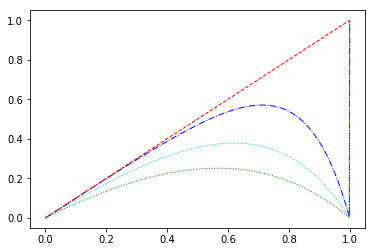

In [15]:
plt.figure(0)
for j, m in enumerate(methods):
    plt.plot(np.linspace(0., 1., num=npts), data[:,j], ls[j], label=m, lw=1)
plt.legend()

In [16]:
ave = 0.1
for i, nvar in enumerate(np.linspace(0., 1., num=npts)):
    for j, m in enumerate(methods):
        data[i, j] = beta_integration(v, v, ave, nvar, method=m)

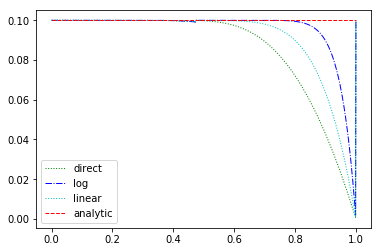

In [17]:
plt.figure(1)
for j, m in enumerate(methods):
    plt.plot(np.linspace(0., 1., num=npts), data[:,j], ls[j], label=m, lw=1)
plt.legend()